Instalamos e importamos las bibliotecas necesarios

In [1]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession

Creamos una sesión de Sparl llamada 'StudentPerformance'

In [2]:
spark = SparkSession.builder.appName('StudentPerformance').getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Subimos el archivo y lo leemos

In [17]:
df = spark.read.csv("/content/StudentPerformance.csv", header=True, inferSchema=True, sep=";")
df.printSchema()
df.show(5)

root
 |-- index: integer (nullable = true)
 |-- race_ethnicity: string (nullable = true)
 |-- parental_education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test_preparation_course: string (nullable = true)
 |-- math_percentage: double (nullable = true)
 |-- reading_percentage: double (nullable = true)
 |-- writing_percentage: double (nullable = true)
 |-- sex: string (nullable = true)

+-----+--------------+------------------+------------+-----------------------+---------------+------------------+------------------+---+
|index|race_ethnicity|parental_education|       lunch|test_preparation_course|math_percentage|reading_percentage|writing_percentage|sex|
+-----+--------------+------------------+------------+-----------------------+---------------+------------------+------------------+---+
|    0|       group B| bachelor's degree|    standard|                   none|           0.72|              0.72|              0.74|  F|
|    1|       group C|      some colle

Vamos a ver la estructura de datos

In [18]:
df.printSchema()  # Estructura
df.describe().show()  # Estadísticas

root
 |-- index: integer (nullable = true)
 |-- race_ethnicity: string (nullable = true)
 |-- parental_education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test_preparation_course: string (nullable = true)
 |-- math_percentage: double (nullable = true)
 |-- reading_percentage: double (nullable = true)
 |-- writing_percentage: double (nullable = true)
 |-- sex: string (nullable = true)

+-------+-----------------+--------------+------------------+------------+-----------------------+-------------------+-------------------+------------------+----+
|summary|            index|race_ethnicity|parental_education|       lunch|test_preparation_course|    math_percentage| reading_percentage|writing_percentage| sex|
+-------+-----------------+--------------+------------------+------------+-----------------------+-------------------+-------------------+------------------+----+
|  count|             1000|          1000|              1000|        1000|                   1000

Nivel educativo padres, calificaciones

In [28]:
df.groupBy("parental_education").agg(
    {"math_percentage": "avg", "reading_percentage": "avg", "writing_percentage": "avg"}
).show()

+------------------+-----------------------+--------------------+-----------------------+
|parental_education|avg(writing_percentage)|avg(math_percentage)|avg(reading_percentage)|
+------------------+-----------------------+--------------------+-----------------------+
|  some high school|     0.6488826815642459|  0.6349720670391062|     0.6693854748603356|
|associate's degree|      0.698963963963964|  0.6788288288288293|     0.7092792792792795|
|       high school|     0.6244897959183671|  0.6213775510204079|     0.6470408163265308|
| bachelor's degree|      0.733813559322034|  0.6938983050847456|     0.7300000000000003|
|   master's degree|     0.7567796610169494|  0.6974576271186439|      0.753728813559322|
|      some college|     0.6884070796460179|  0.6712831858407079|     0.6946017699115047|
+------------------+-----------------------+--------------------+-----------------------+



A mayor nivel educativo de los padres, mejor desempeño de los estudiantes.
Los estudiantes cuyos padres tienen un máster tienen los promedios más altos en todas las áreas:
- Escritura: 0.7568
- Matemáticas: 0.6975
- Lectura: 0.7537

Esto sugiere que los padres con mayor educación pueden influir positivamente en el rendimiento académico de sus hijos.
Los puntajes más bajos están en estudiantes con padres que solo tienen secundaria.
"High school" (Secundaria terminada) y "Some high school" (No terminaron secundaria) tienen los valores más bajos en todas las áreas:
- Escritura: 0.6245 - 0.6489
- Matemáticas: 0.6214 - 0.6350
- Lectura: 0.6470 - 0.6694

Esto podría indicar menos apoyo académico en casa o menos acceso a recursos educativos.

El rendimiento en lectura y escritura es más alto que en matemáticas.

En todos los niveles educativos, el promedio de lectura y escritura es superior al de matemáticas.

Podríamos indicar que los estudiantes encuentran más dificultad en matemáticas, o que las estrategias de enseñanza en matemáticas son menos efectivas.

Procedemos a pintar un gráfico para ver estos resultados

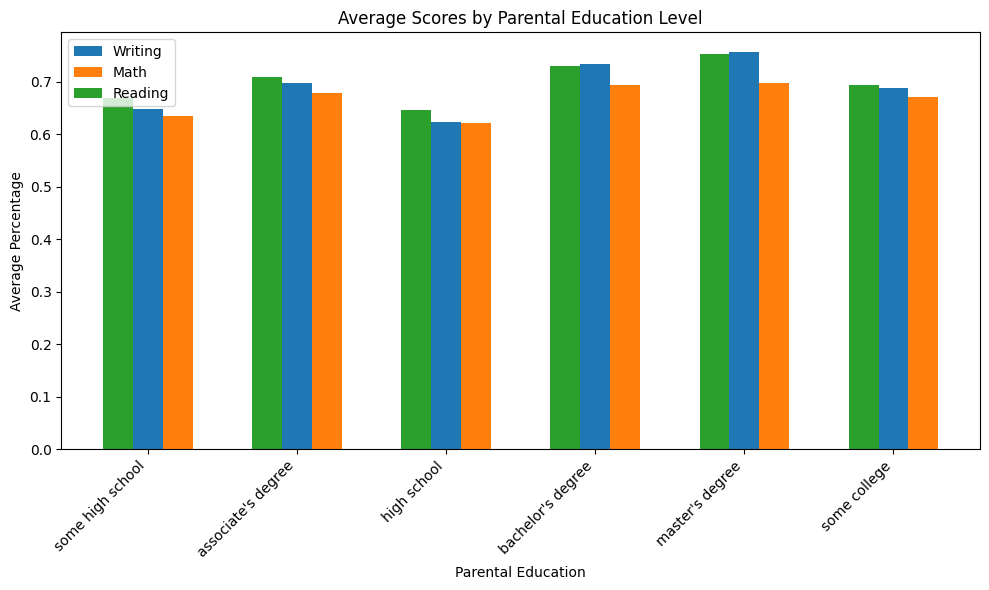

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir el DataFrame de Spark a un DataFrame de pandas
df_resultado_pd = df_resultado.toPandas()

# Configurar la gráfica
fig, ax = plt.subplots(figsize=(10, 6))

# Definir el índice para las posiciones en el eje X
x = range(len(df_resultado_pd))

# Crear las barras para las tres categorías
ax.bar(x, df_resultado_pd['avg_writing_percentage'], width=0.2, label='Writing', align='center')
ax.bar([i + 0.2 for i in x], df_resultado_pd['avg_math_percentage'], width=0.2, label='Math', align='center')
ax.bar([i - 0.2 for i in x], df_resultado_pd['avg_reading_percentage'], width=0.2, label='Reading', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Parental Education')
ax.set_ylabel('Average Percentage')
ax.set_title('Average Scores by Parental Education Level')
ax.set_xticks(x)
ax.set_xticklabels(df_resultado_pd['parental_education'], rotation=45, ha='right')

# Añadir leyenda
ax.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

 ¿Afecta el tipo de almuerzo al rendimiento en escritura?

In [31]:
df.groupBy("lunch").agg({"writing_percentage": "avg"}).show()

+------------+-----------------------+
|       lunch|avg(writing_percentage)|
+------------+-----------------------+
|free/reduced|     0.6302253521126763|
|    standard|     0.7082325581395355|
+------------+-----------------------+



Vemos que el almuerzo reducido o sin almuerzo, el rendimiento en la lectura es peor, concliomos que realizar un almuerzo ayuda al desempeño en esta habilidad.

¿Cuál es la nota media en matemáticas del grupo A?

In [35]:
from pyspark.sql import functions as func

# Filtrar el DataFrame para "group A" y calcular el promedio de math_percentage
df.filter(df["race_ethnicity"] == "group A").select(
    func.avg(df["math_percentage"]).alias("avg_math_percentage")
).show()

+-------------------+
|avg_math_percentage|
+-------------------+
| 0.6162921348314606|
+-------------------+



Vamos a realizar un análisis un poco más completo:

Primero realizaremos un análisis. Calcularemos las correlaciones entre las tres asignaturas.

A continuación, visualizaremos el promediado por etnia y nivel educativo de los padres, con un gráfico de barras.

Finalmente, visualización de la interacción entre género, nivel educativo de los padres y puntajes.


Correlación matemáticas - lectura: 0.8175796636720513
Correlación matemáticas - escritura: 0.8026420459498078
Correlación lectura - escritura: 0.9545980771462471


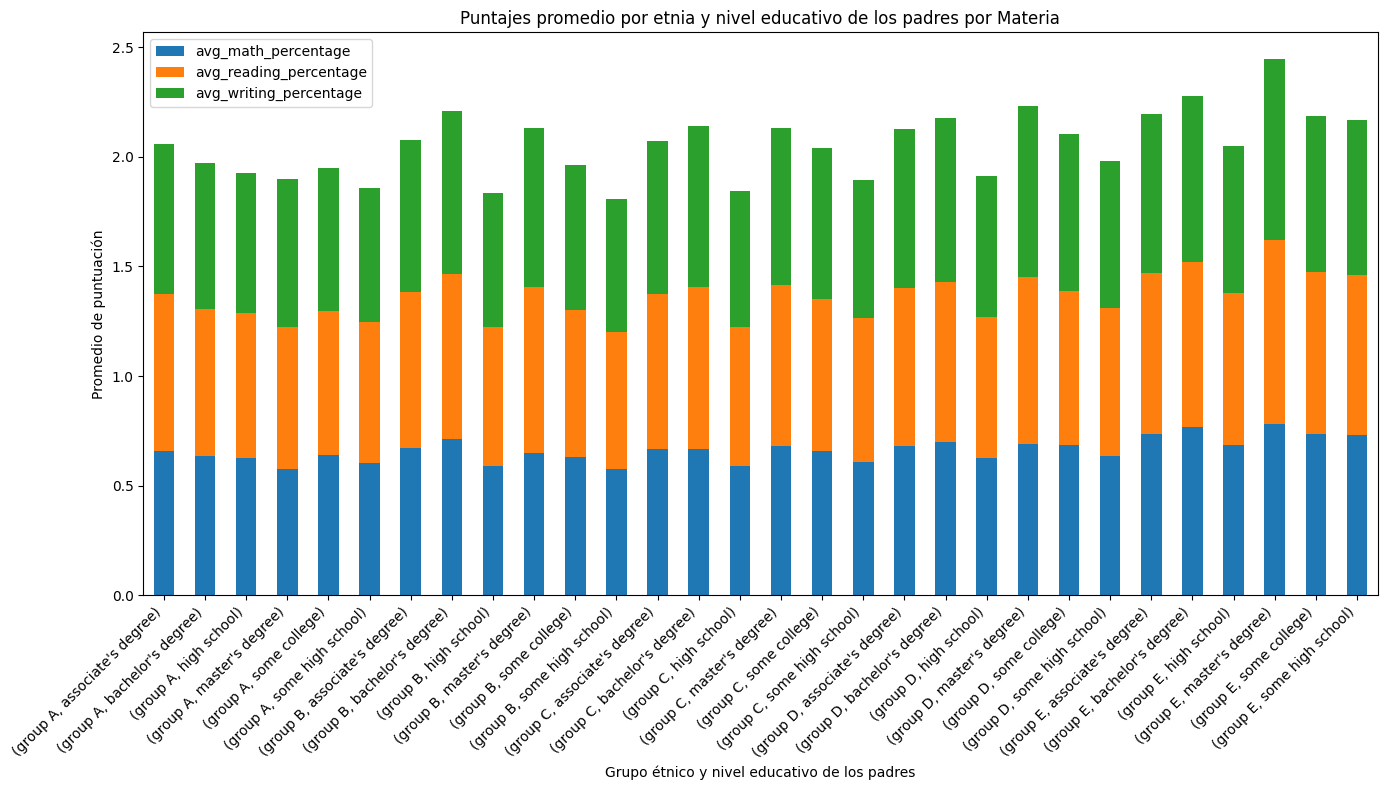

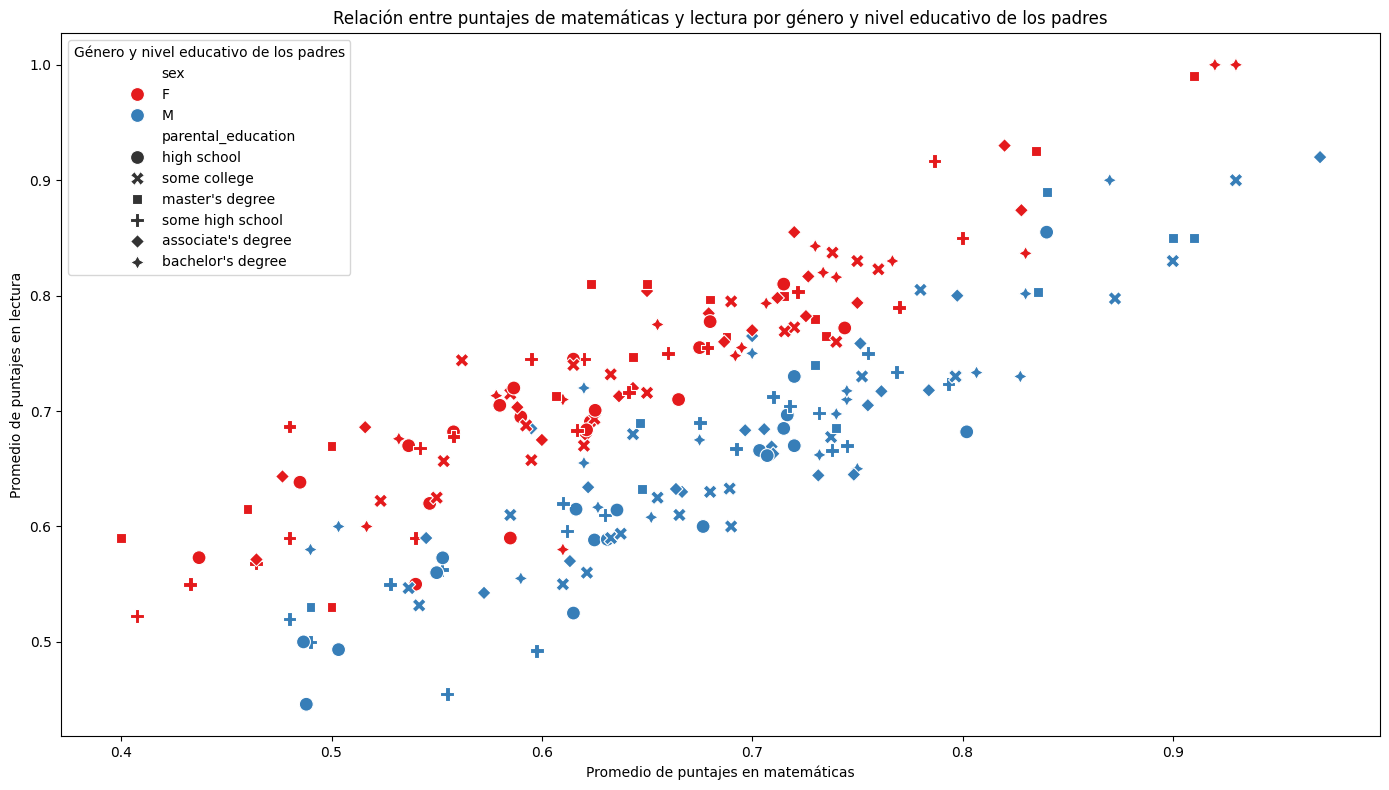

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F

# Agrupamos por variables categóricas y calcular los puntajes promedio por grupo
df_aggregated = df.groupBy("race_ethnicity", "parental_education", "lunch", "test_preparation_course", "sex").agg(
    F.avg("math_percentage").alias("avg_math_percentage"),
    F.avg("reading_percentage").alias("avg_reading_percentage"),
    F.avg("writing_percentage").alias("avg_writing_percentage")
)

# Convertimos el DF de Spark a Pandas para trabajar con matplot y seaborn
df_aggregated_pd = df_aggregated.toPandas()

# Calculamos las correlaciones entre las tres asignaturas

corr_math_reading = df.corr("math_percentage", "reading_percentage")
corr_math_writing = df.corr("math_percentage", "writing_percentage")
corr_reading_writing = df.corr("reading_percentage", "writing_percentage")

print(f"Correlación matemáticas - lectura: {corr_math_reading}")
print(f"Correlación matemáticas - escritura: {corr_math_writing}")
print(f"Correlación lectura - escritura: {corr_reading_writing}")

# Visualización de los puntajes promedio por etnia y nivel educativo de los padres

# Definimos los colores para cada asignatura
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Creamos la figura y los ejes
plt.figure(figsize=(14, 8))

# Creamos un gráfico de barras para las tres materias agrupadas por etnia y nivel educativo
pivot = df_aggregated_pd.pivot_table(
    index=["race_ethnicity", "parental_education"],
    values=["avg_math_percentage", "avg_reading_percentage", "avg_writing_percentage"],
    aggfunc="mean"
)

# Graficar las barras apiladas
pivot.plot(kind="bar", stacked=True, color=colors, figsize=(14, 8), ax=plt.gca())

# Añadimos las etiquetas y título
plt.title("Puntajes promedio por etnia y nivel educativo de los padres por Materia")
plt.xlabel("Grupo étnico y nivel educativo de los padres")
plt.ylabel("Promedio de puntuación")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostramos el gráfico
plt.show()

# Visualización de la interacción entre género, nivel educativo de los padres y puntajes con un gráfico de dispersión

# Creamos un gráfico de dispersión
plt.figure(figsize=(14, 8))

# Graficamos los puntajes de matemáticas por género y nivel educativo de los padres
sns.scatterplot(data=df_aggregated_pd, x='avg_math_percentage', y='avg_reading_percentage', hue='sex', style='parental_education', palette='Set1', s=100)

plt.title('Relación entre puntajes de matemáticas y lectura por género y nivel educativo de los padres')
plt.xlabel('Promedio de puntajes en matemáticas')
plt.ylabel('Promedio de puntajes en lectura')
plt.legend(title="Género y nivel educativo de los padres")
plt.tight_layout()

# Mostramos el gráfico
plt.show()


Las correlaciones entre las materias indican que hay una relación positiva fuerte entre las puntuaciones en matemáticas, lectura y escritura.

Matemáticas y lectura tienen una relación bastante fuerte, lo que sugiere que los estudiantes con buenas habilidades matemáticas también tienden a tener buenas habilidades de lectura.

La correlación entre lectura y escritura es aún más fuerte, lo que resalta la conexión directa entre estas dos habilidades lingüísticas.

En general, este análisis sugiere que las habilidades cognitivas generales de los estudiantes pueden influir en su desempeño en varias asignaturas, y las habilidades lingüísticas como son la lectura y escritura, parecen estar más estrechamente relacionadas entre sí en comparación con las matemáticas.

Podemos analizar en el gráfico de barras.

- Rendimiento académico y etnia: El gráfico muestra el rendimiento académico promedio en matemáticas, lectura y escritura, categorizado por grupos étnicos (A, B, C, D, E) y el nivel educativo de los padres.

- Impacto del nivel educativo de los padres: Se observa una tendencia general donde un mayor nivel educativo de los padres suele correlacionarse con un mejor rendimiento académico de los estudiantes en todas las materias.

- Variabilidad entre grupos étnicos: Existen diferencias notables en el rendimiento promedio entre los distintos grupos étnicos, lo que sugiere que factores socioeconómicos y culturales pueden influir en el desempeño académico.

- Grupo A: Muestra una clara progresión en el rendimiento a medida que aumenta el nivel educativo de los padres, siendo el grupo con padres con máster el de mejor desempeño.

- Grupo B: Exhibe una variabilidad interesante. Los estudiantes con padres con bachillerato y máster tienen un rendimiento relativamente alto, mientras que aquellos con padres con menor educación muestran un desempeño más bajo.

- Grupo C: Similar al Grupo A, se observa una correlación positiva entre el nivel educativo de los padres y el rendimiento académico. Sin embargo, el rendimiento general parece ser ligeramente inferior en comparación con los Grupos A y B.

- Grupo D: Presenta una tendencia similar a los grupos anteriores, aunque el impacto del nivel educativo de los padres parece ser menos pronunciado.

- Grupo E: Muestra una amplia gama de rendimiento, con los estudiantes cuyos padres tienen bachillerato y máster obteniendo los mejores resultados.

- Materias: En general, el rendimiento en matemáticas tiende a ser ligeramente inferior en comparación con lectura y escritura en la mayoría de los grupos.

- Factores Socioeconómicos: Es probable que los factores socioeconómicos jueguen un papel importante en estas diferencias de rendimiento. Los grupos étnicos con niveles educativos parentales más altos pueden tener acceso a más recursos y apoyo educativo.

Finalmente, los resultados del gráfico de dispersión reflejas.

En un primer análisis general:

- Relación positiva: El gráfico muestra una clara relación positiva entre los puntajes de matemáticas y lectura. A medida que aumentan los puntajes en matemáticas, también tienden a aumentar los puntajes en lectura, y viceversa.

- Género: Hay diferencias notables en la distribución de los puntajes entre hombres (M) y mujeres (F). Las mujeres tienden a tener puntajes más altos en lectura, mientras que los hombres muestran una mayor variabilidad en matemáticas.

- Nivel educativo de los padres: El nivel educativo de los padres parece influir en el rendimiento académico de los estudiantes. Los estudiantes cuyos padres tienen niveles educativos más altos (licenciatura, máster) tienden a tener puntajes más altos en ambas materias.

Con un análisis algo más detallado observamos:

- Mujeres (F):
  - Muestran una distribución más concentrada en el extremo superior del eje de lectura.
  - Los puntajes en matemáticas son más variables, pero tienden a ser más altos para aquellas con padres con niveles educativos superiores.
- Hombres (M):
  - Presentan una mayor variabilidad en los puntajes de matemáticas.
  - Aunque también muestran una correlación positiva entre matemáticas y lectura, la dispersión es mayor en comparación con las mujeres.
  - También se observa que los puntajes tienden a ser más altos cuando los padres tienen niveles educativos superiores.
- Nivel Educativo de los Padres:
  - Bachillerato y máster: Los estudiantes cuyos padres tienen estos niveles educativos tienden a agruparse en la parte superior derecha del gráfico, indicando un rendimiento más alto en ambas materias.
  - Educación secundaria incompleta y completa: Los estudiantes con padres en estos niveles educativos muestran una mayor dispersión, con puntajes que varían desde bajos hasta relativamente altos.
  - Algún título unifersitario y título de técnico: Los estudiantes en estos grupos muestran una distribución intermedia en términos de rendimiento.

Adicionalmente tenemos que destacar.

- Correlación fuerte entre matemáticas y lectura: La correlación positiva sugiere que los estudiantes que se desempeñan bien en matemáticas también tienden a hacerlo bien en lectura, lo que podría indicar habilidades cognitivas generales o factores comunes que influyen en ambas materias.
- Factores socioeconómicos: El nivel educativo de los padres puede estar relacionado con factores socioeconómicos que influyen en el rendimiento académico, como el acceso a recursos educativos, el apoyo en el hogar y las expectativas académicas.